In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz


In [ ]:
!tar -xvzf /kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [18]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    'CUB_200_2011/images/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 11788 files belonging to 200 classes.


In [19]:
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

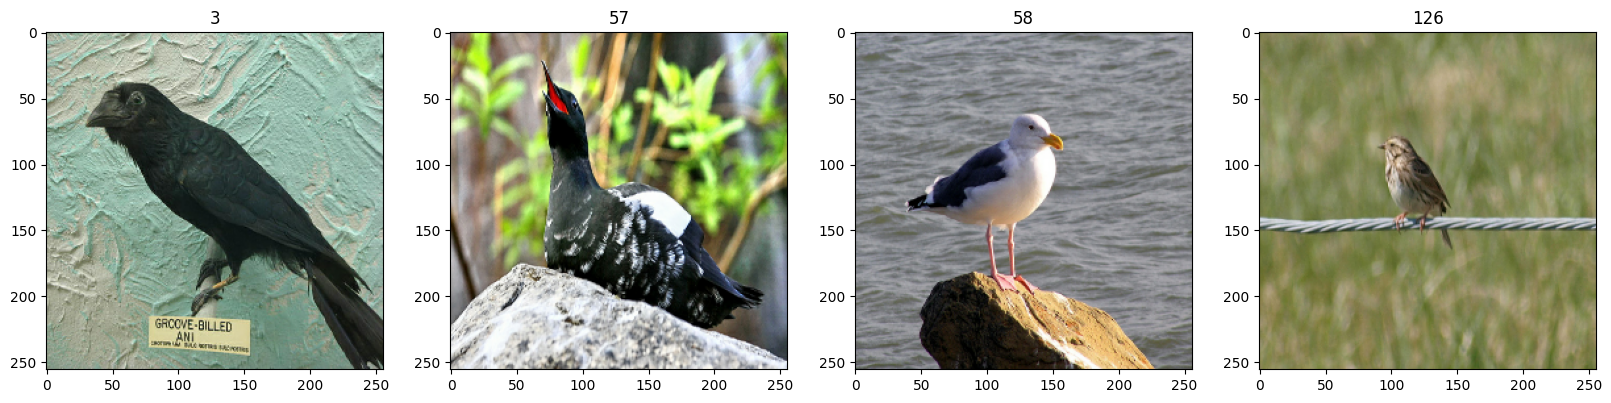

In [20]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [21]:
data=data.map(lambda x, y: (x/255, y))

In [22]:
train_size = 8252
val_size = 1178
test_size = 2358

train_data = data.take(train_size)
test_data = data.take(test_size)
val_data = data.take(val_size)

Epoch 1/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.0050 - loss: 5.4040 - val_accuracy: 0.0102 - val_loss: 5.2804
Epoch 2/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.0118 - loss: 5.2516 - val_accuracy: 0.0154 - val_loss: 5.1434
Epoch 3/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.0253 - loss: 5.0696 - val_accuracy: 0.0639 - val_loss: 4.8548
Epoch 4/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.0575 - loss: 4.7973 - val_accuracy: 0.1134 - val_loss: 4.4818
Epoch 5/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.1321 - loss: 4.4080 - val_accuracy: 0.1805 - val_loss: 3.9855
Epoch 6/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.2341 - loss: 3.9620 - val_accuracy: 0.2844 - val_loss: 3.6044
Epoch 7/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.3543 - loss: 3.5447 - val_accuracy: 0.4583 - val_loss: 3.1964
Epoch 8/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.4726 - loss: 3.1781 - 

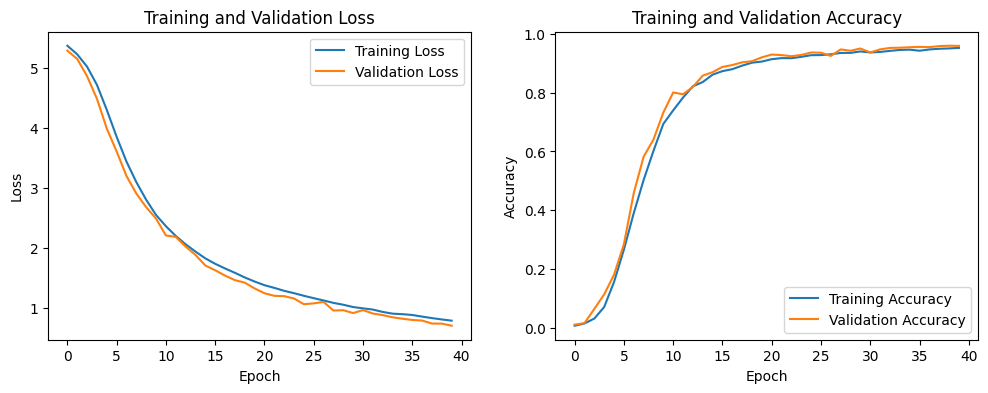

In [54]:
model=Sequential([  
  Conv2D(8, (3,3), 1, activation='relu'),
  BatchNormalization(),
  MaxPooling2D((2,2)),  
  Flatten(),
  Dense(8, activation='relu'),
  BatchNormalization(),  
  Dense(200, activation='softmax', kernel_regularizer=l2(0.01))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, epochs=40, validation_data=val_data)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [55]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test accuracy:', test_accuracy*100.0,'%')

369/369 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9607 - loss: 0.7122
Test accuracy: 95.97047567367554 %


In [ ]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 254, 254, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 129032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │     1,032,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 200)            │         1,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,102,994 (11.84 MB)

 Trainable params: 1,034,320 (3.95 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 2,068,642 (7.89 MB)